<a href="https://colab.research.google.com/github/egonloch/DNC/blob/main/Desafio_7_Egon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Business Understanding

Uma empresa de e-commerce que está buscando entender melhor o comportamento de seus clientes para personalizar as suas campanhas de marketing. Para isso, a empresa disponibilizou uma base de dados em csv contendo dados sobre clientes, produtos e transações da loja realizadas entre os anos de 2010 e 2011.

Com base nesses dados, você precisa agrupar os clientes em clusters com base em
seu comportamento de compra.
- Clientes que compram os mesmos produtos;
- Clientes que possuem a mesma frequência de compras;
- Clientes que gastam mais dinheiro em suas compras.

Os dados fornecidos possuem informações de transações de compras de uma loja de
e-commerce em 38 países e territórios, com mais de 4.000 clientes únicos e mais de
540.000 transações.

#Data Understanding

## Setup

In [2]:
%%capture
%pip install sidetable

In [60]:
import numpy as np
import pandas as pd
import sidetable

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, scale
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from mlxtend.preprocessing import TransactionEncoder

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from yellowbrick.cluster import kelbow_visualizer

In [4]:
# customização dos graficos
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

In [5]:
# carregar o dataset
df = pd.read_csv('https://raw.githubusercontent.com/cmcouto-silva/datasets/main/datasets/e-commerce.csv', encoding='latin1')
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Data understanding

In [6]:
#verificar o tipo das colunas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
#verificar se existe dados com letras
df.InvoiceNo.sort_values()

0          536365
1          536365
2          536365
3          536365
4          536365
           ...   
540449    C581490
541541    C581499
541715    C581568
541716    C581569
541717    C581569
Name: InvoiceNo, Length: 541909, dtype: object

In [8]:
#verificar a quantidade valores unicos de países e descriçoes
df[['Description','Country']].nunique()

Description    4223
Country          38
dtype: int64

In [9]:
#verificar valores negativos
df[['Quantity','UnitPrice']].describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


<Axes: ylabel='Country'>

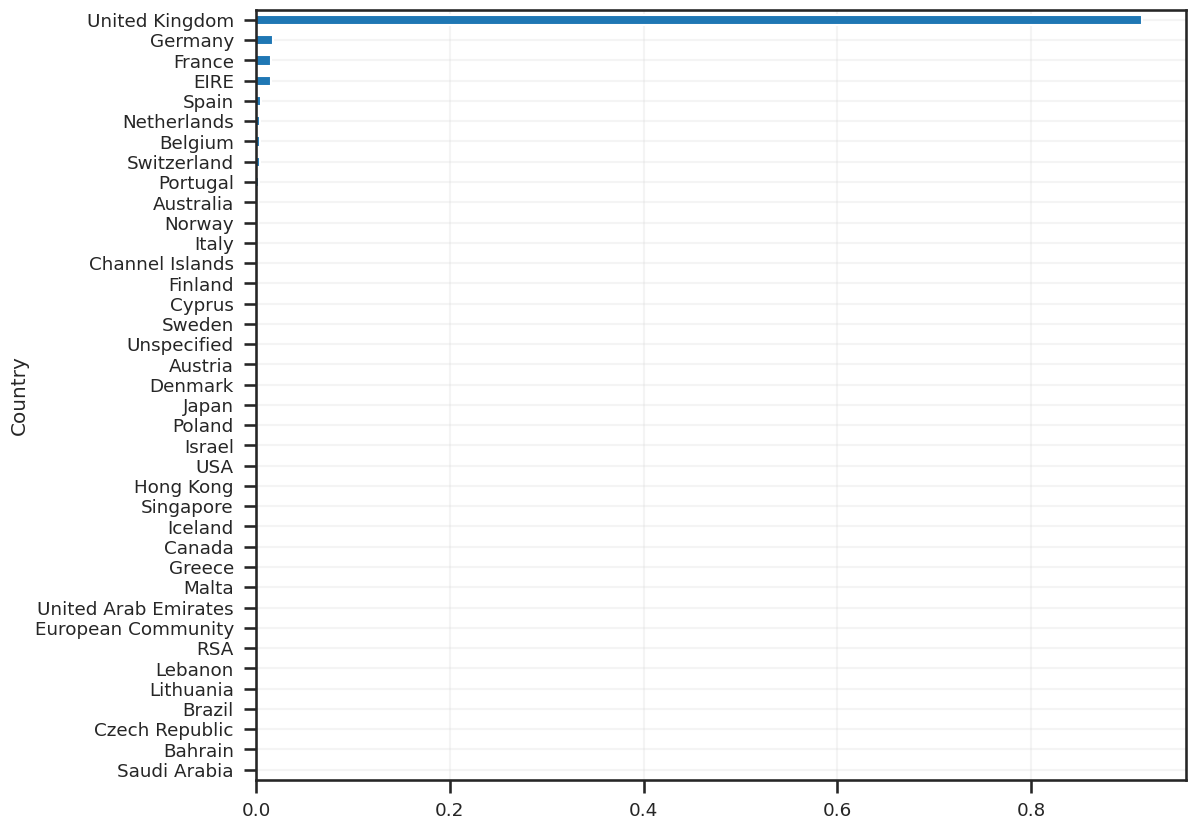

In [10]:
#quantidade em cada país
df['Country'].value_counts(normalize=True, ascending=True).plot.barh(figsize=(12,10))

In [11]:
#frequencia de cada país
df.stb.freq(['Country'])

,Country,count,percent,cumulative_count,cumulative_percent
0,United Kingdom,495478,91.431956,495478,91.431956
1,Germany,9495,1.752139,504973,93.184095
2,France,8557,1.579047,513530,94.763143
3,EIRE,8196,1.512431,521726,96.275574
4,Spain,2533,0.467422,524259,96.742996
5,Netherlands,2371,0.437527,526630,97.180523
6,Belgium,2069,0.381798,528699,97.562321
7,Switzerland,2002,0.369435,530701,97.931756
8,Portugal,1519,0.280305,532220,98.212061
9,Australia,1259,0.232327,533479,98.444388


In [12]:
#verificar valores faltantes
df.isna().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

In [13]:
#verificar valores duplicados
df.duplicated().sum()

5268

#Data Preparation

In [14]:
#estatísticas sobre os valores ausentes
df.stb.missing()

,missing,total,percent
CustomerID,135080,541909,24.926694
Description,1454,541909,0.268311
InvoiceNo,0,541909,0.000000
StockCode,0,541909,0.000000
Quantity,0,541909,0.000000
InvoiceDate,0,541909,0.000000
UnitPrice,0,541909,0.000000
Country,0,541909,0.000000


In [15]:
#remover valores ausentes
df = df.dropna(subset=['CustomerID'])

In [16]:
#verificar valores ausentes
df.stb.missing()

,missing,total,percent
InvoiceNo,0,406829,0.0
StockCode,0,406829,0.0
Description,0,406829,0.0
Quantity,0,406829,0.0
InvoiceDate,0,406829,0.0
UnitPrice,0,406829,0.0
CustomerID,0,406829,0.0
Country,0,406829,0.0


In [17]:
#converter a coluna data
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, format='%m/%d/%Y %H:%M')

<ipython-input-17-d63ca5a70a87>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, format='%m/%d/%Y %H:%M')


In [18]:
#converter colunas id, cliente e país
df['CustomerID'] = df['CustomerID'].astype(int)
df['Country'] = df['Country'].astype('category')

<ipython-input-18-245f7defd67e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CustomerID'] = df['CustomerID'].astype(int)
<ipython-input-18-245f7defd67e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Country'] = df['Country'].astype('category')


In [19]:
df = df.copy()

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  int64         
 7   Country      406829 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 25.2+ MB


In [21]:
#identificar dados abaixo de 0
below0 = df[['Quantity','UnitPrice']].le(0).any(axis=1)
df = df[~below0].copy()

<Axes: >

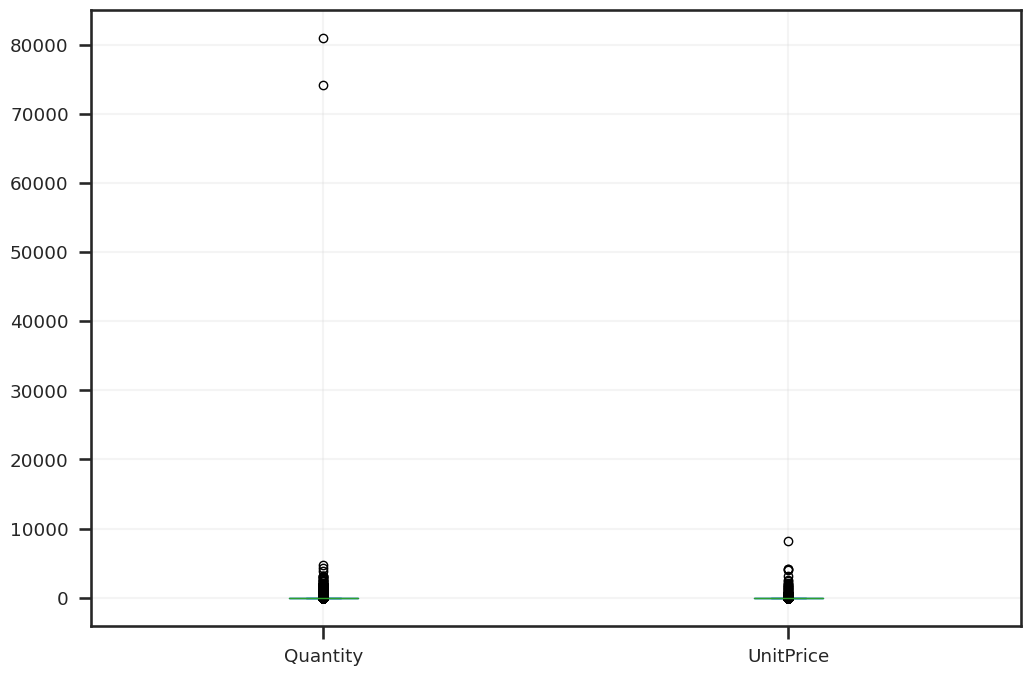

In [22]:
#identificar outliers
df[['Quantity','UnitPrice']].plot.box()

In [23]:
#verificar outliers
df.query('Quantity>10_000')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom


<Axes: >

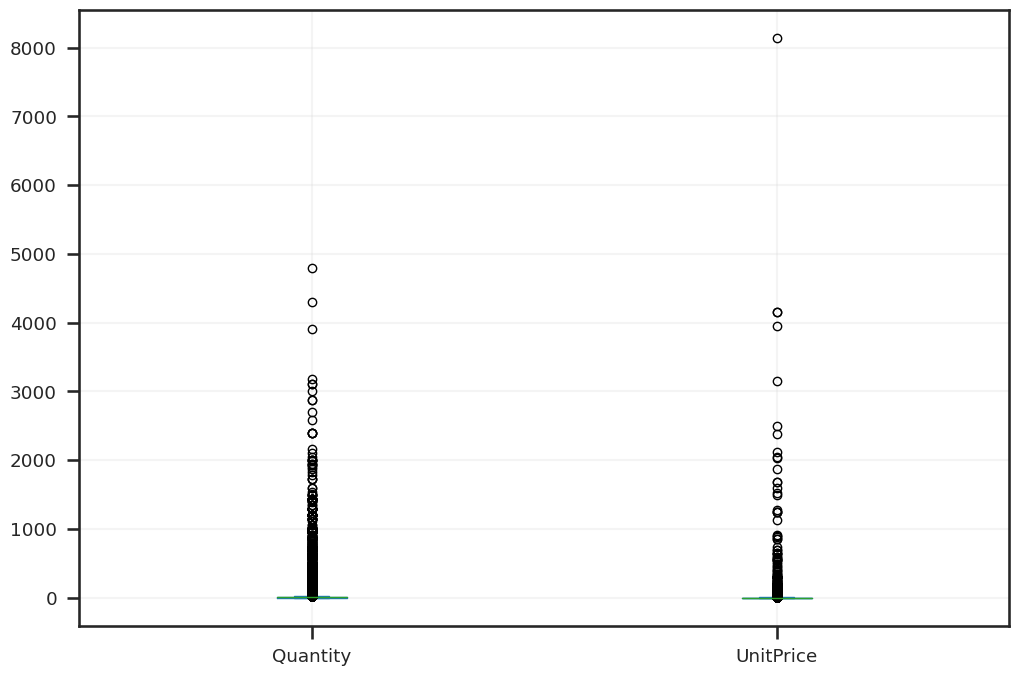

In [24]:
df.query('Quantity<10_000')[['Quantity','UnitPrice']].plot.box()

In [25]:
df.query('UnitPrice>8_000')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom


In [26]:
df = df.query('Quantity<10_000 & UnitPrice<8_000').copy()

In [27]:
df['price_total'] = df.Quantity * df.UnitPrice
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,price_total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60


# Analise de produtos

##Análise de Cesta de Mercado (Market Basket Analysis)


In [69]:
# Criar uma cópia do DataFrame para nao modificar o original
df_copy = df.copy()

# Contar a frequência de cada StockCode na cópia
stock_counts = df_copy['StockCode'].value_counts()

# Definicão do limite de categorias principais de acordo com o valor silhouette_score calculado a seguir
top_n = 5
top_categories = stock_counts.nlargest(top_n).index

# Agrupar categorias menos frequentes como 'Outros' na cópia do DataFrame
df_copy['StockCode'] = df_copy['StockCode'].apply(lambda x: x if x in top_categories else 'Outros')

# Verificar o resultado na cópia do DataFrame
print(df_copy['StockCode'].value_counts())

StockCode
Outros    389701
85123A      2035
22423       1723
85099B      1618
84879       1408
47566       1396
Name: count, dtype: int64


In [61]:
# Pré-processamento dos dados para a análise de cesta de mercado
transactions = df_copy.groupby(['InvoiceNo'])['StockCode'].apply(list).values.tolist()
te = TransactionEncoder()
te_ary = te.fit_transform(transactions)
transactions_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Normalizar os dados usando StandardScaler
scaler = StandardScaler()
transactions_scaled = scaler.fit_transform(transactions_encoded)

In [63]:
# Create list of dictionaries
cluster_metrics_results = []
X = transactions_scaled.copy()

for k in range(2, 11):
    model = KMeans(n_clusters=k, random_state=0, n_init='auto')
    labels = model.fit_predict(X)
    silhouette_avg = silhouette_score(X, labels)  # Calculando a métrica de Silhueta
    cluster_results_dict = {'k': k}
    cluster_results_dict['inertia'] = model.inertia_
    cluster_results_dict['silhouette_score'] = silhouette_avg
    cluster_metrics_results.append(cluster_results_dict)

# Convertendo para DataFrame e estilizando a apresentação
result_df = pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()
result_df

,inertia,silhouette_score
k,,
2,92318.697445,0.614569
3,76029.698964,0.667720
4,57659.636511,0.674162
5,42448.061860,0.724828
6,30200.025253,0.792248
7,18722.757306,0.875980
8,16288.970639,0.886269
9,14337.094401,0.899780
10,12564.613385,0.910645


In [70]:
# Aplicar o algoritmo de clustering (K-means) nos dados normalizados
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(transactions_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [64]:
# Visualização dos centroides dos clusters gerados pelo algoritmo K-means
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=transactions_encoded.columns)

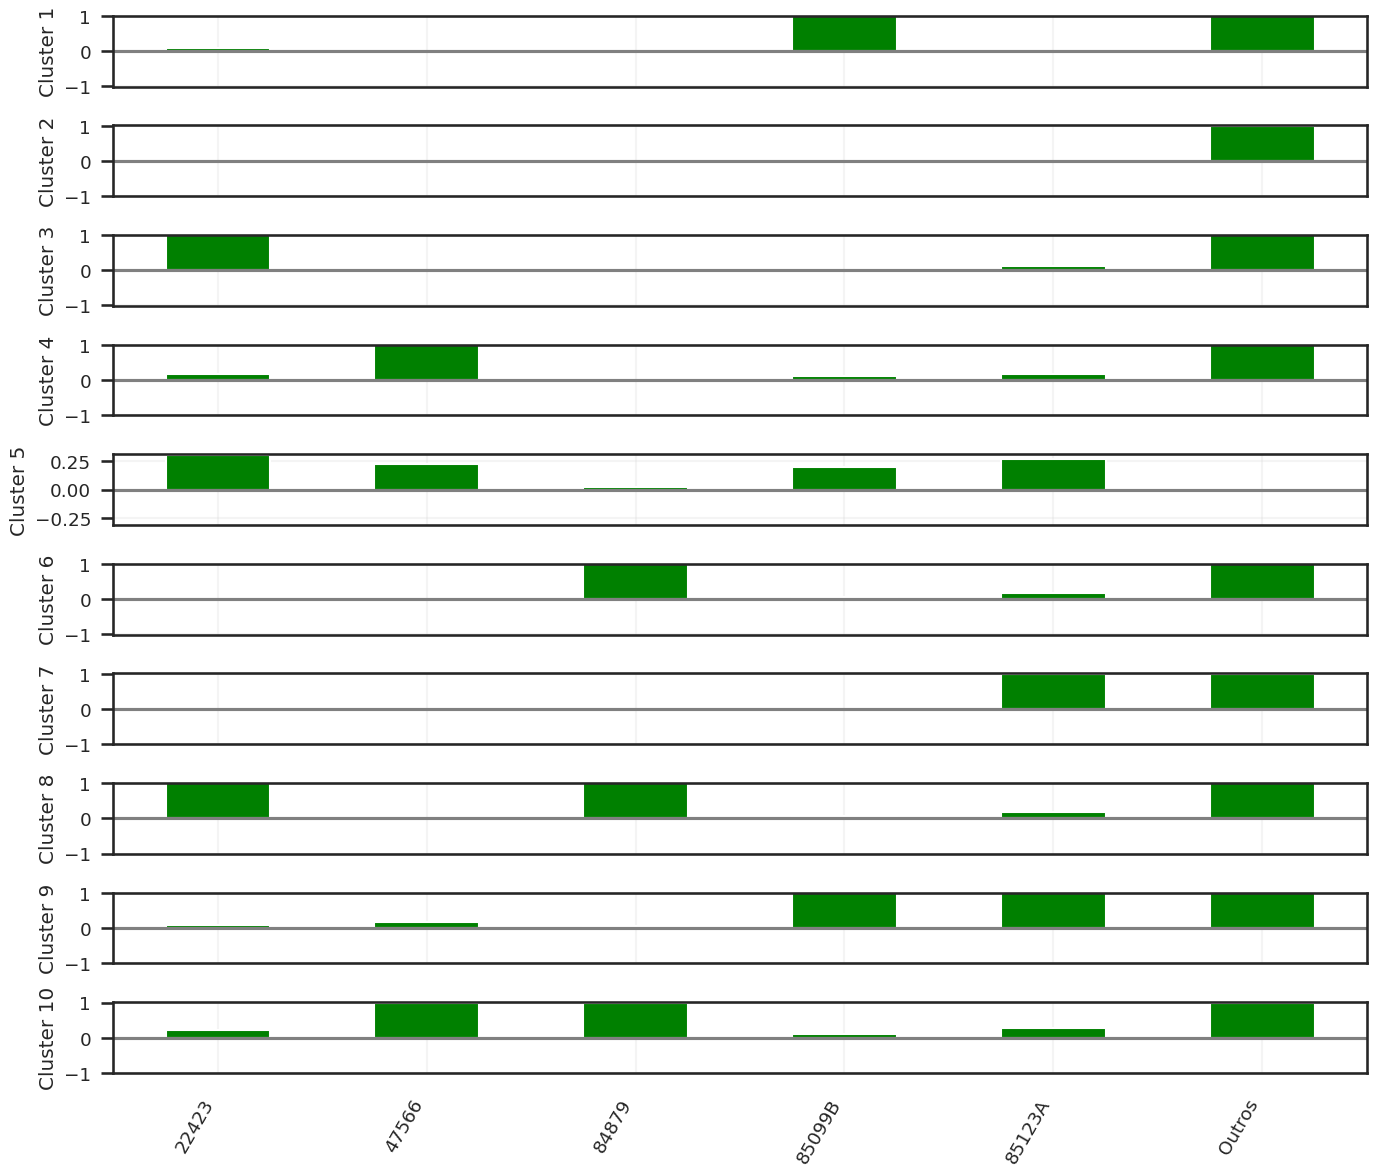

In [65]:
fig, axes = plt.subplots(nrows=n_clusters, figsize=(14, 12), sharex=True)

for i, ax in enumerate(axes):
    center = centers.iloc[i, :]
    maxPC = 1.01 * center.abs().max()
    colors = ['green' if l > 0 else 'red' for l in center]
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster {i+1}')
    ax.set_ylim(-maxPC, maxPC)
    ax.axhline(color='gray')
    ax.xaxis.set_ticks_position('none')

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [71]:
# visualização das médias das métricas por cluster
transactions_encoded['cluster'] = clusters
mean_by_cluster = transactions_encoded.groupby('cluster').mean().transpose()
styled_mean_by_cluster = mean_by_cluster.style.background_gradient(cmap='YlOrRd', axis=1)
styled_mean_by_cluster

cluster,0,1,2,3,4,5,6,7,8,9
22423,0.083110,0.000000,1.000000,0.163265,0.310811,0.000000,0.000000,1.000000,0.087866,0.207254
47566,0.000000,0.000000,0.000000,1.000000,0.229730,0.000000,0.000000,0.000000,0.175732,1.000000
84879,0.000000,0.000000,0.000000,0.000000,0.027027,1.000000,0.000000,1.000000,0.050209,1.000000
85099B,1.000000,0.000000,0.000000,0.107365,0.202703,0.070624,0.000000,0.083770,1.000000,0.108808
85123A,0.000000,0.000000,0.113814,0.160603,0.270270,0.172979,1.000000,0.178010,1.000000,0.290155
Outros,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#Perfil dos produtos cada cluster de clientes

**Cluster 0**

* Produtos dominantes: 85099B (1.000000), Outros (1.000000)
* Características: Este cluster é caracterizado por uma forte presença do produto 85099B. A categoria "Outros" também está presente com alta frequência. Este cluster parece ser dominado por um produto específico e uma categoria genérica.

**Cluster 1**
* Produtos dominantes: Outros (1.000000)
* Características: Este cluster é exclusivamente dominado pela categoria "Outros". Isso sugere que este cluster agrupa clientes que compram uma variedade de produtos não frequentemente comprados o suficiente para serem categorizados individualmente.

**Cluster 2**
* Produtos dominantes: 22423 (1.000000), 85123A (0.113814)
* Características: Este cluster é fortemente dominado pelo produto 22423. A presença de 85123A é muito baixa. Este cluster é altamente específico a um único produto.

**Cluster 3**
* Produtos dominantes: 47566 (1.000000), Outros (1.000000), 85099B (0.107365)
* Características: Este cluster é caracterizado por uma forte presença do produto 47566 e da categoria "Outros". O produto 85099B também está presente, mas com uma frequência menor.

**Cluster 4**
* Produtos dominantes: 22423 (0.310811), 47566 (0.229730), 85123A (0.270270), 85099B (0.202703)
* Características: Este cluster mostra uma distribuição mais balanceada entre vários produtos, com uma presença moderada de 22423, 47566, 85123A e 85099B. Parece ser um cluster diversificado com preferência por vários produtos.

**Cluster 5**
* Produtos dominantes: 84879 (1.000000), Outros (1.000000), 85123A (0.172979)
* Características: Este cluster é caracterizado por uma forte presença do produto 84879 e da categoria "Outros". O produto 85123A também está presente, mas com uma frequência menor.

**Cluster 6**
* Produtos dominantes: 85123A (1.000000), Outros (1.000000)
* Características: Este cluster é fortemente dominado pelo produto 85123A e pela categoria "Outros". Isso indica uma clara preferência por este produto específico entre os clientes deste cluster.

**Cluster 7**
* Produtos dominantes: 22423 (1.000000), 84879 (1.000000)
* Características: Este cluster é caracterizado por uma forte presença dos produtos 22423 e 84879. Os clientes deste cluster parecem ter uma preferência clara por esses dois produtos.

**Cluster 8**
* Produtos dominantes: 47566 (0.175732), Outros (1.000000)
* Características: Este cluster é dominado pela categoria "Outros", com uma presença moderada do produto 47566. Este cluster pode representar clientes com um comportamento de compra mais diversificado.

**Cluster 9**
* Produtos dominantes: 47566 (1.000000), 84879 (1.000000), 85099B (1.000000), 85123A (1.000000), Outros (1.000000)
* Características: Este cluster mostra uma forte presença de múltiplos produtos, incluindo 47566, 84879, 85099B e 85123A, além da categoria "Outros". Este é um cluster muito diversificado, com clientes que compram uma variedade ampla de produtos.

**Conclusão Geral**
* Clusters 1 e 6: Altamente genéricos com uma presença dominante da categoria "Outros".
* Clusters 0, 2, 3, 5, 7: Dominados por um ou dois produtos específicos.
* Cluster 4: Diversificado com vários produtos representados de maneira mais balanceada.
* Cluster 9: Muito diversificado, com uma presença forte de vários produtos e da categoria "Outros".

## **RFM**

Calculo de RFM para determinar clientes que possuem a mesma frequência de compra e clientes que gastam mais dinheiro em suas compras

In [29]:
#como é um df antigo, foi utilizada a ultima data encontrada
ultima_data = df['InvoiceDate'].max()
ultima_data

Timestamp('2011-12-09 12:50:00')

In [30]:
#calculo do RFM
df_rfm = (
  df.groupby('CustomerID')
  .agg(
      R = ('InvoiceDate', lambda x: (pd.Timestamp('2011-12-09 12:50:00') - x.max()).days),
      F = ('InvoiceNo', 'nunique'),
      M = ('price_total', 'mean')
  )
)

df_rfm

,R,F,M
CustomerID,,,
12347,1,7,23.681319
12348,74,4,57.975484
12349,18,1,24.076027
12350,309,1,19.670588
12352,35,8,29.482824
...,...,...,...
18280,277,1,18.060000
18281,180,1,11.545714
18282,7,2,14.837500


<Axes: >

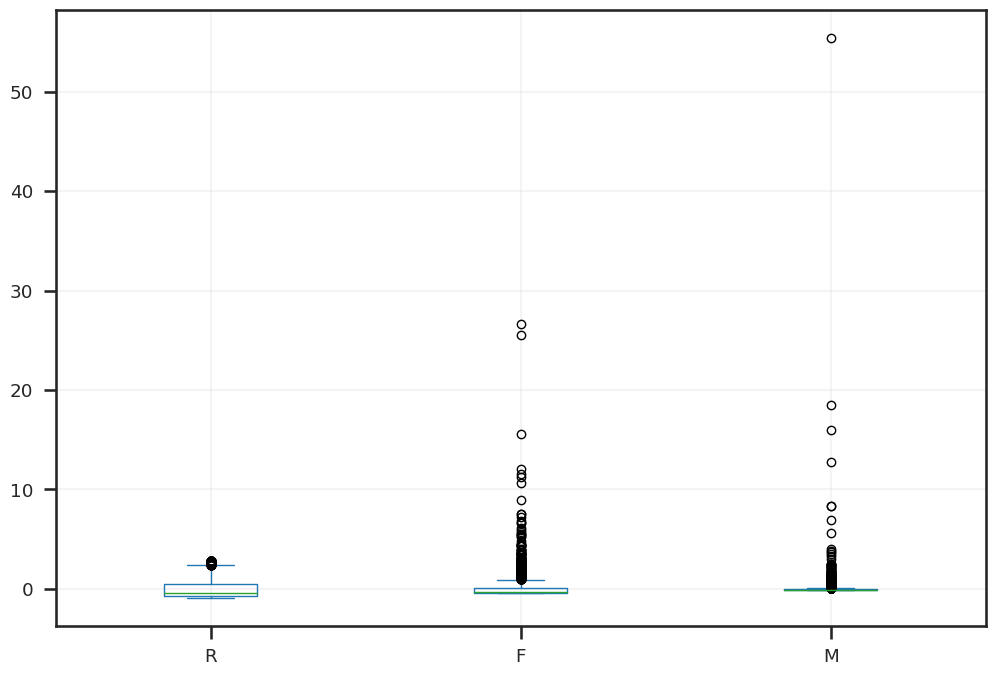

In [31]:
#analise de como os dados estao se comportando com escala padronizada
df_rfm.apply(scale).plot.box()

In [32]:
#identificaçao do cliente outlier
df_rfm.apply(scale).query('M>50')

,R,F,M
CustomerID,,,
15098,0.895091,-0.165317,55.434876


In [33]:
#verificar o cliente
df.query('CustomerID==15098')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,price_total
222670,556442,22502,PICNIC BASKET WICKER SMALL,60,2011-06-10 15:22:00,4.95,15098,United Kingdom,297.0
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098,United Kingdom,38970.0
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098,United Kingdom,649.5


In [34]:
#remover o cliente
df_rfm = df_rfm.drop(15098)

<Axes: >

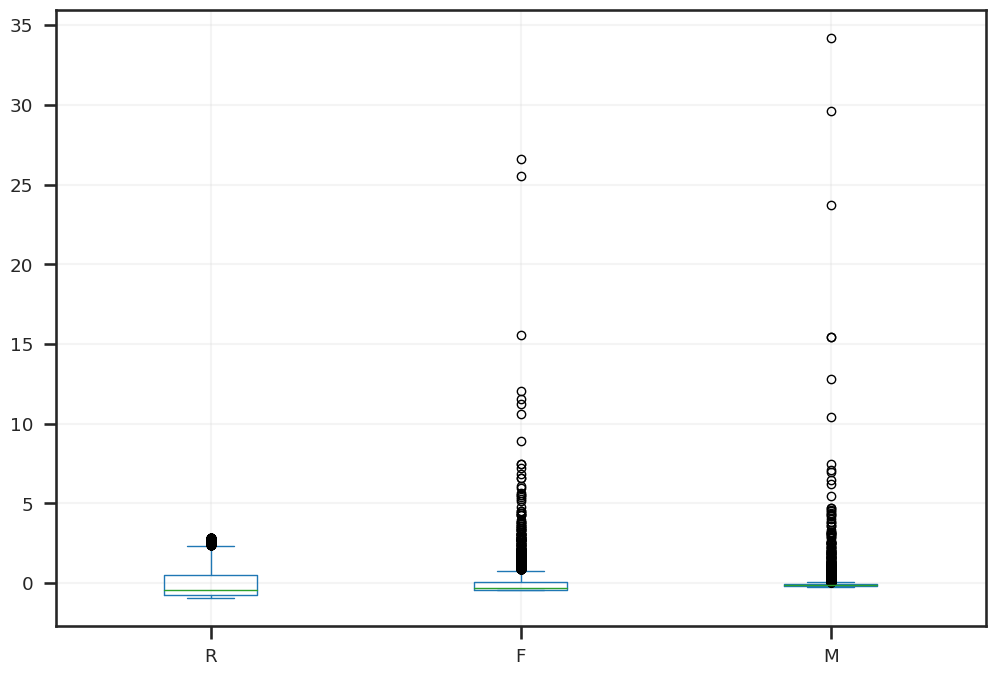

In [35]:
#verificar outros outliers
df_rfm.apply(scale).plot.box()

In [36]:
#padronização dos dados
scaler = PowerTransformer()
df_rfm_scaled = pd.DataFrame(scaler.fit_transform(df_rfm), index=df_rfm.index, columns=df_rfm.columns)
df_rfm_scaled

,R,F,M
CustomerID,,,
12347,-1.843196,1.201866,0.407836
12348,0.291366,0.660670,1.329304
12349,-0.679767,-1.158070,0.426829
12350,1.573774,-1.158070,0.189376
12352,-0.256739,1.309671,0.653411
...,...,...,...
18280,1.463610,-1.158070,0.085562
18281,1.049619,-1.158070,-0.491003
18282,-1.181793,-0.195707,-0.161007


<Axes: >

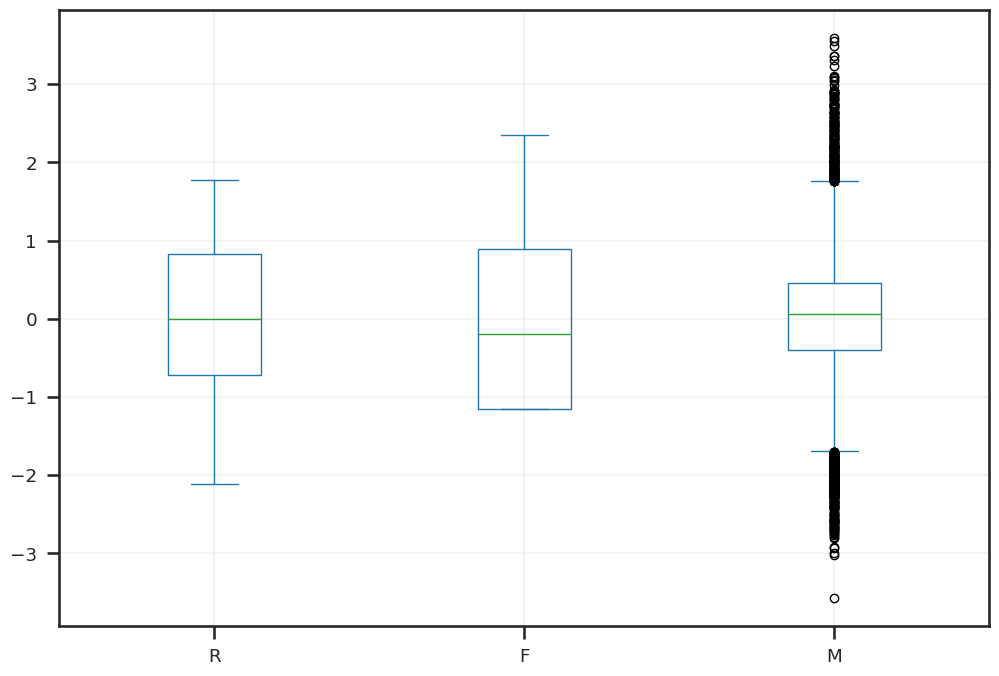

In [37]:
#visualizar a distribuição dos dados
df_rfm_scaled.plot.box()

In [38]:
#analisar se ainda existe grandes variaçoes
df_rfm.describe()

,R,F,M
count,4336.000000,4336.000000,4336.000000
mean,91.509225,4.272601,34.554185
std,99.970323,7.697927,129.202663
min,0.000000,1.000000,1.450000
25%,17.000000,1.000000,12.339095
50%,50.000000,2.000000,17.715999
75%,141.000000,5.000000,24.843993
max,373.000000,209.000000,4453.430000


In [39]:
#limitando para valores até 95%
df_rfm_clip = df_rfm.apply(lambda x: x.clip(upper=x.quantile(.95)))
df_rfm_clip.describe()

,R,F,M
count,4336.000000,4336.000000,4336.000000
mean,89.750231,3.608164,23.634656
std,95.564917,3.358999,20.993635
min,0.000000,1.000000,1.450000
25%,17.000000,1.000000,12.339095
50%,50.000000,2.000000,17.715999
75%,141.000000,5.000000,24.843993
max,311.000000,13.000000,91.768421


In [40]:
#entrada para modeling
df_rfm_clip_scaled = df_rfm_clip.apply(scale)
df_rfm_clip_scaled

,R,F,M
CustomerID,,,
12347,-0.928798,1.009892,0.002223
12348,-0.164831,0.116666,1.635962
12349,-0.750888,-0.776560,0.021026
12350,2.294514,-0.776560,-0.188844
12352,-0.572977,1.307634,0.278601
...,...,...,...
18280,1.959625,-0.776560,-0.265571
18281,0.944491,-0.776560,-0.575905
18282,-0.866006,-0.478818,-0.419088


#Modeling & Model evaluation RFM

## K-Means RFM

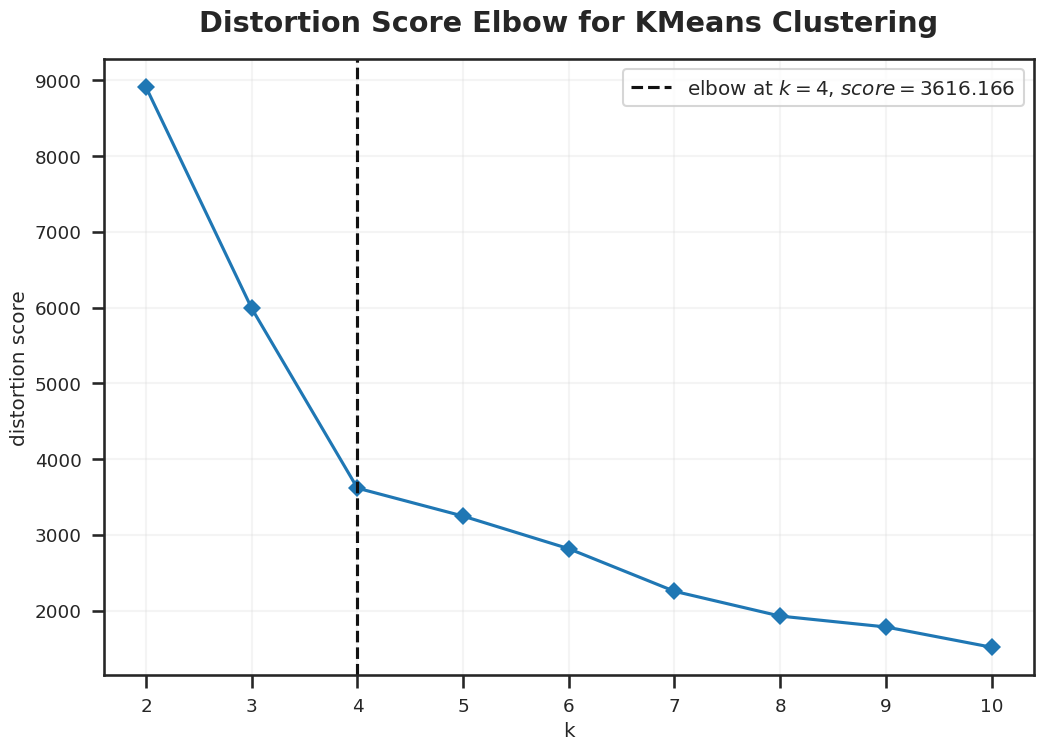

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10, n_init='auto'), timings=False)

In [67]:
#determinação do número ideal de clusters
kelbow_visualizer(KMeans(n_init='auto'), df_rfm_clip_scaled, k=10, timings=False)

In [68]:
# calcula várias métricas de avaliação de clusters para determinar o melhor numero de clusters
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_rfm_clip_scaled.copy()

for k in range(2,11):
  model = KMeans(n_clusters=k, random_state=0, n_init='auto')
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,8907.267426,0.382701,1.064209,1995.291729
3,5988.503446,0.434858,0.858010,2539.490911
4,3616.173734,0.479609,0.705117,3750.319778
5,3052.550900,0.476268,0.759384,3531.309725
6,2543.164050,0.397696,0.851392,3563.493253
7,2255.012116,0.402185,0.831559,3440.504813
8,1907.142443,0.383579,0.861990,3598.840594
9,1669.010181,0.394099,0.800518,3674.629275
10,1516.752511,0.351753,0.887370,3641.660853


In [43]:
#cria um modelo de clustering K-means com 4 clusters
kmeans = KMeans(4, n_init='auto')
kmeans_labels = kmeans.fit_predict(df_rfm_clip_scaled)

In [44]:
#gráfico de dispersão tridimensional
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=kmeans_labels.astype(str), template='plotly_dark')

## Hierarchical Clustering

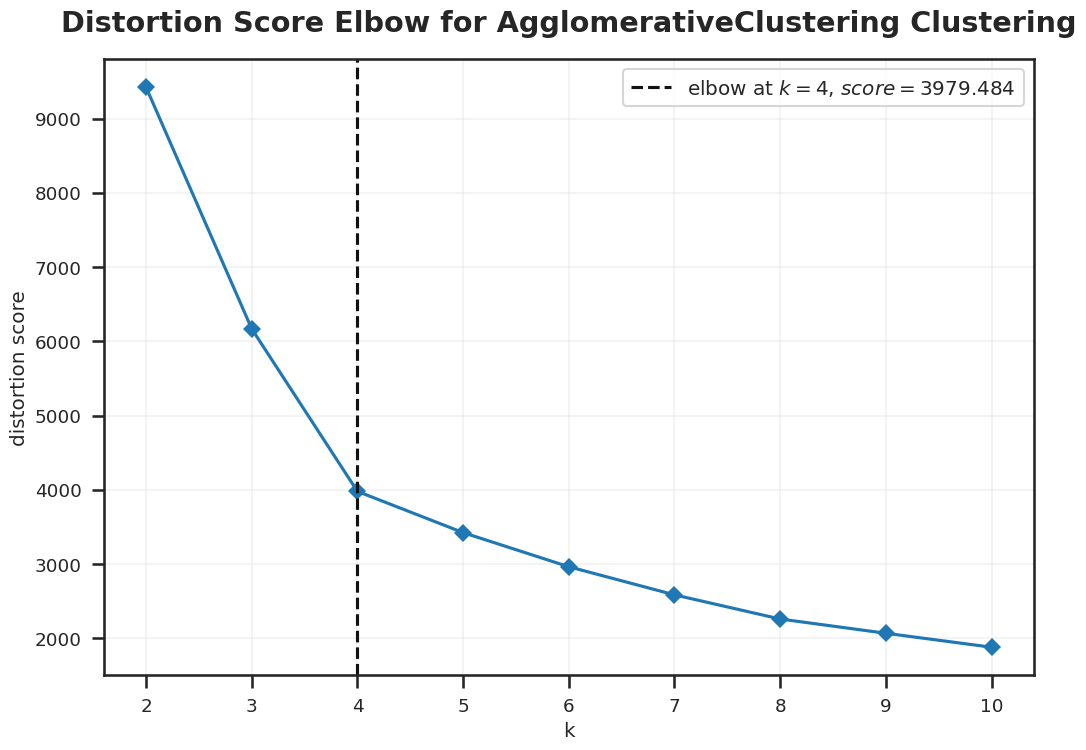

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=AgglomerativeClustering(n_clusters=10),
                 timings=False)

In [45]:
#determinação do número ideal de clusters
kelbow_visualizer(AgglomerativeClustering(), df_rfm_clip_scaled, k=10, timings=False)

In [46]:
# calcula várias métricas de avaliação de clusters
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_rfm_clip_scaled.copy()

for k in range(2,11):
  model = AgglomerativeClustering(n_clusters=k)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  # cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,
2,0.366218,1.401714,1649.165249
3,0.410780,0.877315,2402.355257
4,0.426824,0.804797,3276.097867
5,0.433213,0.724893,3030.574661
6,0.413187,0.773614,2933.915283
7,0.348179,0.839594,2907.682809
8,0.352214,0.872310,2939.438121
9,0.277369,1.006623,2860.314633
10,0.293698,1.001754,2844.258180


In [47]:
#cria um modelo de Hierarchical Clustering com 4 clusters
hclust = AgglomerativeClustering(n_clusters=4)
hclust_labels = hclust.fit_predict(df_rfm_clip_scaled)

In [48]:
#gráfico de dispersão tridimensional
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=hclust_labels.astype(str), template='plotly_dark')

## Gaussian Mixture

In [49]:
#análise de clustering gaussiano
results = []
k_range = range(1,9)
covariance_types = ['full', 'tied', 'diag', 'spherical']
X = df_rfm_clip_scaled.copy()

for n_components in k_range:
  for covariance_type in covariance_types:
    mclust = GaussianMixture(n_components=n_components, n_init=10, warm_start=True, covariance_type=covariance_type)
    mclust.fit(X)
    results.append({
      'bic': mclust.bic(X),
      'n_components': n_components,
      'covariance_type': covariance_type,
    })

results = pd.DataFrame(results)
results.sort_values('bic').head()

,bic,n_components,covariance_type
30,-226.155007,8,diag
28,13.694935,8,full
26,214.458453,7,diag
24,221.972845,7,full
22,8983.034831,6,diag


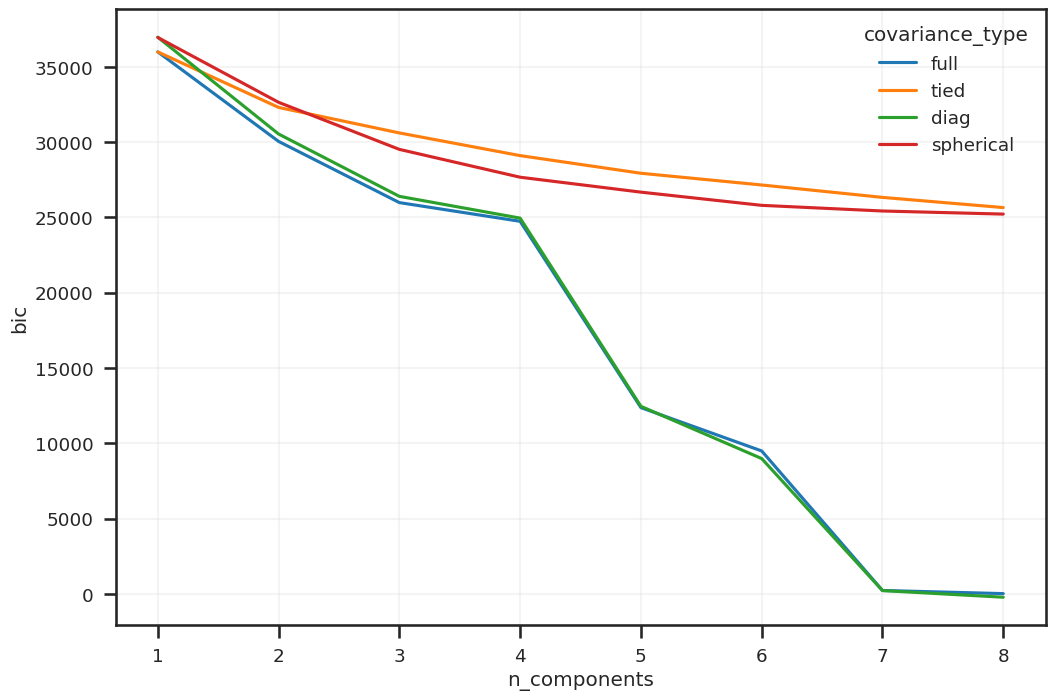

In [50]:
# gráfico de linha que mostra como o critério de informação bayesiano (BIC) varia em relação ao número de componentes dos modelos GMM para diferentes tipos de covariância
sns.lineplot(data=results, x='n_components', y='bic', hue='covariance_type');

In [51]:
#Este código cria um modelo de clustering Gaussiano (Gaussian Mixture Model - GMM) com 5 componentes
mclust = GaussianMixture(n_components=5, covariance_type='full', n_init=10)
mclust_labels = mclust.fit_predict(df_rfm_clip_scaled)

In [52]:
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=mclust_labels.astype(str), template='plotly_dark')

#Interpretação dos clusters RFM

In [53]:
#cria um df que contém as coordenadas dos centroides dos clusters encontrados pelo algoritmo K-means.
centers = pd.DataFrame(kmeans.cluster_centers_, columns=df_rfm_clip_scaled.columns)

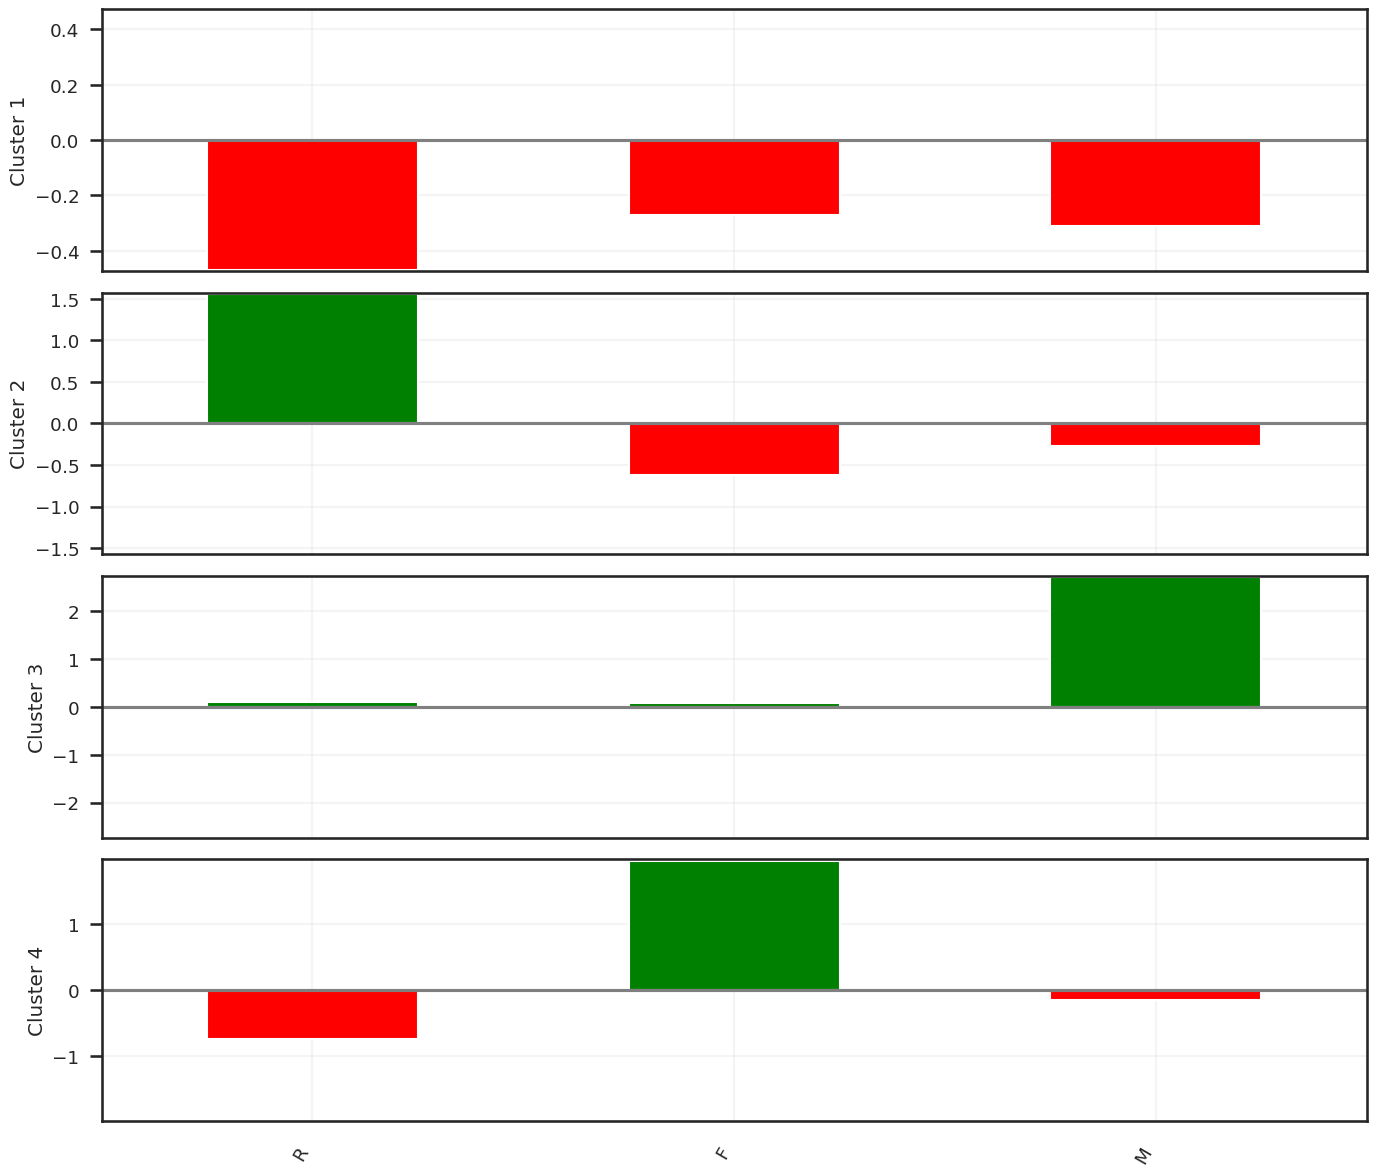

In [54]:
#visualizaçao dos centroides dos clusters gerados pelo algoritmo K-means
fig,axes = plt.subplots(nrows=4, figsize=(14,12), sharex=True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none')

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [72]:
#visualização das médias das métricas por cluster
df_rfm_clip['cluster'] = kmeans_labels
mean_by_cluster = df_rfm_clip.groupby('cluster').mean().transpose()
styled_mean_by_cluster = mean_by_cluster.style.background_gradient(cmap='YlOrRd', axis=1)
styled_mean_by_cluster


cluster,0,1,2,3
R,44.982523,238.800617,98.852500,19.017828
F,2.702472,1.512847,3.862500,10.191248
M,17.107621,18.030163,80.496497,20.426973


#Perfil de compras dos clientes de cada cluster RFM

**Cluster 0 (Clientes Ativos e Moderados):**

Recency (R): Baixa. Indica que os clientes nesse cluster interagiram ou compraram recentemente.

Frequency (F): Moderada a alta. Os clientes desse cluster têm uma frequência de compra razoável.

Monetary (M): Baixa a moderada. O valor médio gasto em cada compra é relativamente baixo.

Perfil do Cliente (Cluster 0):
Clientes desse cluster são ativos em termos de frequência de compra, mas também tendem a gastar menos em cada compra. Eles podem ser clientes que fazem compras regulares de produtos de baixo a médio valor.

**Cluster 1 (Clientes Inativos ou de Baixo Valor):**

Recency (R): Alta. Indica que os clientes nesse cluster não interagiram ou compraram recentemente.

Frequency (F): Baixa. Os clientes desse cluster não fazem compras com muita frequência.

Monetary (M): Baixa. Os valores gastos em cada compra são baixos.

Perfil do Cliente (Cluster 1):
Clientes desse cluster estão inativos e não contribuem muito para o faturamento da empresa. Eles podem ser clientes ocasionais que compram produtos de baixo valor esporadicamente.

**Cluster 2 (Clientes em Potencial ou Retenção):**

Recency (R): Moderada. Os clientes desse cluster fizeram compras recentemente ou estão retornando.

Frequency (F): Baixa a moderada. Os clientes desse cluster não fazem compras com muita frequência.

Monetary (M): Moderado a alto. O valor médio gasto em cada compra varia.

Perfil do Cliente (Cluster 2):
Clientes desse cluster podem estar em processo de retenção ou representam oportunidades de vendas futuras. Eles podem ter feito compras recentemente, mas não são compradores frequentes. O valor gasto varia, o que pode indicar diferentes tipos de clientes dentro deste cluster.

**Cluster 3 (Clientes Ativos e Valiosos):**

Recency (R): Moderada a alta. Isso sugere que os clientes nesse cluster não interagiram ou compraram recentemente.

Frequency (F): Moderada a alta. Os clientes desse cluster têm uma frequência de compra significativa.

Monetary (M): Baixa a moderada. Apesar da frequência de compra, o valor médio gasto em cada compra é relativamente baixo.

Perfil do Cliente (Cluster 3):
Clientes desse cluster são ativos em termos de frequência de compra, mas tendem a gastar menos em cada transação. Eles podem ser clientes que compram produtos de baixo valor com frequência ou clientes que estão mais interessados em promoções e ofertas.



# Sugestões

**Cluster 0 (Clientes Ativos e Moderados)**
- Enviar newsletters regulares com novidades, promoções e ofertas especiais para incentivar compras mais frequentes.
- Implementar programas de referência ou indicação
- Criar programas de recompensa por compras recorrentes

**Cluster 1 (Clientes Inativos ou de Baixo Valor)**
- Enviar campanhas de reativação personalizadas
- Realizar pesquisas de satisfação e feedback para entender as razões da inatividade dos clientes
- Criar programas de recompensa por reativação

**Cluster 2 (Clientes em Potencial ou Retenção)**
- Enviar campanhas de boas-vindas personalizadas para novos clientes .
- Implementar estratégias de upselling e cross-selling
- Criar programas de engajamento para clientes em potencial

**Cluster 3 (Clientes Ativos e Valiosos)**
- Oferecer programas de fidelidade
- Enviar ofertas de recompra personalizadas com base nos produtos comprados anteriormente
- Criar experiências exclusivas para clientes deste cluster

